# Import libraries

In [4]:
# Upload File using ipyfilechooser library
from ipyfilechooser import FileChooser
# Get the root directory of the project
from pyprojroot import here
# Copy File
import shutil
# Widget Packages
import ipywidgets as widgets
# In case widget extension not working
# jupyter nbextension enable --py widgetsnbextension
import os

# Data Exploration Section
R2 (Epic): As a user, I want a "Data Exploration" section in the notebook so that I can load and display video data from the TSU project.

## Video Upload / Choose using ipyfilechooser
R2 (Story): As a user, I want to upload/choose files from the data folder through an appropriate UI component (E.g. Browse files) in a notebook code cell so that I can pick and choose the video data I would like to process

In [5]:
# from ipyfilechooser import FileChooser
def videoselectorinput():
    starting_directory = './data'
    chooser = FileChooser(starting_directory)
    display(chooser)
    return chooser
    
def videoselectoroutput():
    starting_directory = './pipeline/video/output'
    chooser = FileChooser(starting_directory)
    display(chooser)
    return chooser

In [6]:
video = videoselectorinput()

FileChooser(path='C:\Users\Work\Desktop\Projects\ict3104-team05-2022\data', filename='', title='', show_hidden…

## Upload selected file to the data folder (If needed)

In [7]:
# Upload Function
# from pyprojroot import here
# import shutil
def upload(video):
    print(video.selected)
    source = video.selected
    # Source path
    # Destination path
    destination = (here("./data"))

    # Copy file from the selected path
    try:
        shutil.copy(source, destination)
        print("File copied successfully.")

    # If source and destination are same
    except shutil.SameFileError:
        print("Source and destination represents the same file.")

    # If destination is a directory.
    except IsADirectoryError:
        print("Destination is a directory.")

    # If there is any permission issue
    except PermissionError:
        print("Permission denied.")

    # For other errors
    except:
        print("Error occurred while copying file.")

upload(video)

None
Error occurred while copying file.


## Video Playback
R2 (Story): As a user, I want to see video playback of the chosen video file in an output cell so that I can check if it is the right video data I would like to process

In [8]:
# Select Video
video = videoselectorinput()

FileChooser(path='C:\Users\Work\Desktop\Projects\ict3104-team05-2022\data', filename='', title='', show_hidden…

In [9]:
print(video.selected)
print(video.selected_filename)
print(video.selected_path)

None
None
None


In [10]:
from IPython.display import Video

full_path = video.selected
Video(full_path, embed=True, width=540, html_attributes="controls muted autoplay")

TypeError: a bytes-like object is required, not 'NoneType'

<IPython.core.display.Video object>

# Inference Section

R3 (Epic): As a user, I want to have an "Inference" section in the notebook so that I can perform inference using a pretrained HOI ML model based on the TSU project.

## Load a pretrain model
R3 (Story): As a user, I want to load a pre-trained model using an appropriate UI component so that I can easily load the model.

In [11]:
"""
Select the model
"""
modelList = [] 

# Select from the list of model in the pipeline/models folder
for x in os.listdir("./pipeline/models"): 
    modelList += [x]

# Widgets
confirmButton = widgets.Button(
    description='Confirm',
    disabled=False,
    button_style='success',
    icon='check'
)
modelDropdown = widgets.Dropdown(
    options=modelList,
    value=modelList[0],
    description='Model:')
# Function on what happen when confirm is been click.
def selectWidgetSet(b):
    print("Selected: " , modelDropdown.value)

confirmButton.on_click(selectWidgetSet)
modelBox = widgets.VBox([widgets.HBox([modelDropdown, confirmButton])])
modelBox

In [12]:
print(modelDropdown.value)

PDAN_TSU_RGB


## Choose Input video to load into TSU Project
R3 (Story): As a user, I want to choose an  input video files and other related input files, using an appropriate UI component, from the TSU project so that the system is able to pass the right files to the model.

In [13]:
# Select Video
video = videoselectorinput()

FileChooser(path='C:\Users\Work\Desktop\Projects\ict3104-team05-2022\data', filename='', title='', show_hidden…

In [14]:
print(video.selected)
print(video.selected_filename)
print(video.selected_path)

None
None
None


## Run the model 
R3 (Story): As a user, I want to see inference results in the form of an output video with captions that indicate the current detected activity in each video frame so that I am able to see the inference results clearly on the screen.

In [41]:
# Testing
!echo $modelDropdown.value
!echo $video.selected_filename
!echo $video.selected
# Get the directory of the loadmodel
loadmodel = './models/' + modelDropdown.value
!echo $loadmodel

PDAN_TSU_RGB
None
None
./models/PDAN_TSU_RGB


In [55]:
!cd ../../pipeline && python test.py -input_video_full_path $video.selected -input_video_file $video.selected_filename -model $modelDropdown.value -load_model $loadmodel

Random_SEED!!!: 0
PDAN_TSU_RGB
batch_size: 2
cuda_avail True
RGB mode ./data/RGB
Random_SEED!!!: 0
Random_SEED!!!: 0
you are processing PDAN_TSU_RGB
loaded ./models/PDAN_TSU_RGB
pytorch_total_params 5804083
num_channel: 512 input_channnel: 1024 num_classes: 51
0.1
False
val-map: tensor(32.7511)
tensor([43.9296, 50.4119, 45.0844, 45.3014, 40.5055, 43.5343, 33.3114, 30.4521,
        40.9460, 20.7510, 17.2716,  5.1264,  0.7856, 38.4160, 37.8608,  3.3669,
        22.8392, 56.7582,  2.8444, 72.0715, 33.0098, 52.9259, 52.4670,  3.2723,
         1.6550, 63.7364, 37.0699, 52.0327, 60.0214, 15.2961,  6.6451,  0.8588,
        39.0778,  2.8659, 48.3819, 89.2970, 37.7782, 15.1304, 23.2170,  8.0989,
        70.3756, 32.7410, 17.4085, 64.6966,  2.0250, 76.3004, 65.2976, 32.5429,
        11.6490,  2.2110,  0.6536])



100%|##########| 536/536 [00:04<00:00, 132.61it/s]

100%|##########| 536/536 [00:02<00:00, 229.17it/s]
C:\Users\Work\Desktop\Projects\ict3104-team05-2022\pipeline\models.py:88: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.key_conv.weight, mode='fan_out')
C:\Users\Work\Desktop\Projects\ict3104-team05-2022\pipeline\models.py:89: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.value_conv.weight, mode='fan_out')
C:\Users\Work\Desktop\Projects\ict3104-team05-2022\pipeline\models.py:90: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.query_conv.weight, mode='fan_out')
C:\Users\Work\Desktop\Projects\ict3104-team05-2022\pipeline\models.py:91: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(self.rel_t, 0, 1)
C:\Users\Work\Desktop\Projects\ict31

## Output Video to view the inference result 

In [52]:
# Select output video
video = videoselectoroutput()

InvalidPathError: ./pipeline/video/output does not exist

In [53]:
print(video.selected)
print(video.selected_filename)
print(video.selected_path)

None
None
None


In [35]:
from IPython.display import Video

full_path = video.selected
Video(full_path, embed=True, width=540, html_attributes="controls muted autoplay")

TypeError: a bytes-like object is required, not 'NoneType'

<IPython.core.display.Video object>

# Trainng Section
R4 (Epic): As a user, I want to create a "Training" section in the netbook so that I can train a HOI ML model based on the TSU project.

# Testing Section
R5 (Epic): As a user, I want to have a "Testing" section in the notebook so that I can evaluate a trained model based on the TSU project.

# NVIDIA STEP Section
R6 (Epic): As a user, I want to able to configure the notebook using appropriate UI elements coupled with the right .py modules so that R2-5 can be performed based on another pipeline, e.g., the NVIDIA STEP pipeline 

## Pipeline Selection
R6(Story): As a user, I want to create appropriate UI elements to allow for switching pipelines so that I can test the different models



In [20]:
w = widgets.Dropdown(
    options=['TSU', 'NVIDIA SMarthome'],
    value='TSU',
    description='Pipeline:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

w.observe(on_change)

display(w)

Dropdown(description='Pipeline:', options=('TSU', 'NVIDIA SMarthome'), value='TSU')

## Nvidida Step Pipeline
R6(Story): As a user, I want to ensure selected pipeline's dependencies are changed to ensure the right dependencies are given to the appropriate models so that the selected model will be run

In [21]:
%cd ./NVIDIA-STEP-MODEL/STEP

C:\Users\Work\Desktop\Projects\ict3104-team05-2022\NVIDIA-STEP-MODEL\STEP


In [22]:
!pip install ninja

You should consider upgrading via the 'C:\Users\Work\Desktop\Projects\ict3104-team05-2022\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [23]:
!pip install cuda-python

You should consider upgrading via the 'C:\Users\Work\Desktop\Projects\ict3104-team05-2022\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [24]:
!ipython setup.py build develop

running build
running build_py
creating build
creating build\lib.win-amd64-3.8
creating build\lib.win-amd64-3.8\data
copying data\augmentations.py -> build\lib.win-amd64-3.8\data
copying data\ava.py -> build\lib.win-amd64-3.8\data
copying data\ava_cls.py -> build\lib.win-amd64-3.8\data
copying data\customize.py -> build\lib.win-amd64-3.8\data
copying data\data_utils.py -> build\lib.win-amd64-3.8\data
copying data\__init__.py -> build\lib.win-amd64-3.8\data
creating build\lib.win-amd64-3.8\models
copying models\i3dpt.py -> build\lib.win-amd64-3.8\models
copying models\networks.py -> build\lib.win-amd64-3.8\models
copying models\two_branch.py -> build\lib.win-amd64-3.8\models
copying models\__init__.py -> build\lib.win-amd64-3.8\models
creating build\lib.win-amd64-3.8\utils
copying utils\eval_utils.py -> build\lib.win-amd64-3.8\utils
copying utils\solver.py -> build\lib.win-amd64-3.8\utils
copying utils\tube_utils.py -> build\lib.win-amd64-3.8\utils
copying utils\utils.py -> build\lib.wi

C:\Users\Work\Desktop\Projects\ict3104-team05-2022\venv\lib\site-packages\torch\utils\cpp_extension.py:316: UserWarning: Error checking compiler version for cl: [WinError 2] The system cannot find the file specified
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')


In [25]:
!python demo.py

Traceback (most recent call last):
  File "demo.py", line 22, in <module>
    from models import BaseNet, ROINet, TwoBranchNet, ContextNet
  File "C:\Users\Work\Desktop\Projects\ict3104-team05-2022\NVIDIA-STEP-MODEL\STEP\models\__init__.py", line 6, in <module>
    from .networks import BaseNet, ROINet
  File "C:\Users\Work\Desktop\Projects\ict3104-team05-2022\NVIDIA-STEP-MODEL\STEP\models\networks.py", line 14, in <module>
    from external.maskrcnn_benchmark.roi_layers import ROIAlign, ROIPool
  File "C:\Users\Work\Desktop\Projects\ict3104-team05-2022\NVIDIA-STEP-MODEL\STEP\external\maskrcnn_benchmark\roi_layers\__init__.py", line 29, in <module>
    from .nms import nms
  File "C:\Users\Work\Desktop\Projects\ict3104-team05-2022\NVIDIA-STEP-MODEL\STEP\external\maskrcnn_benchmark\roi_layers\nms.py", line 28, in <module>
    from . import _C
ImportError: cannot import name '_C' from partially initialized module 'external.maskrcnn_benchmark.roi_layers' (most likely due to a circular imp

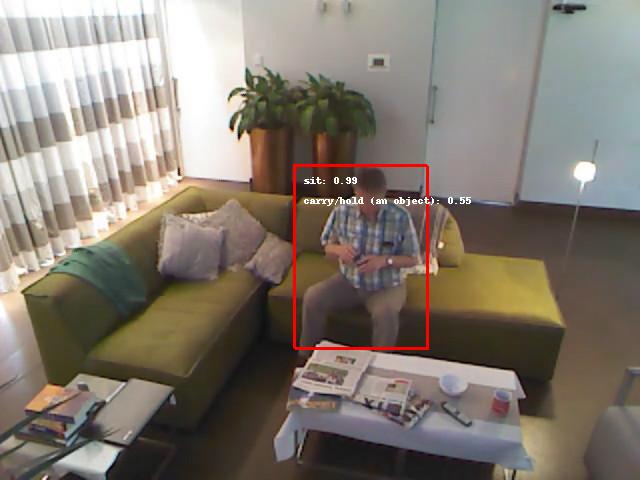

In [26]:
from IPython.display import Image
Image(filename='datasets/demo/frames/results/2/frame0000.jpg') 